In [ ]:
import pandas as pd
clickstream_df = pd.read_csv('/content/drive/MyDrive/ML_Group_Project/click_stream.csv')
transactions_df = pd.read_csv('/content/drive/MyDrive/ML_Group_Project/transactions.csv')
customer_df = pd.read_csv('/content/drive/MyDrive/ML_Group_Project/customer.csv')


In [ ]:
clickstream_df.head()

,session_id,event_name,event_time,event_id,traffic_source,event_metadata
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,"{'product_id': 15315, 'quantity': 4, 'item_pri..."
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,{'payment_status': 'Success'}


In [ ]:
clickstream_df['event_name'].value_counts()

,count
event_name,
CLICK,2498038
HOMEPAGE,2487126
ADD_TO_CART,1937157
SCROLL,1663571
ITEM_DETAIL,1290396
SEARCH,1173266
BOOKING,852582
PROMO_PAGE,604931
ADD_PROMO,326535


In [ ]:
clickstream_df['event_time'] = pd.to_datetime(clickstream_df['event_time'])


In [ ]:
# Step 2: Aggregate per session
session_agg = clickstream_df.groupby('session_id').agg(
    session_duration=('event_time', lambda x: (x.max() - x.min()).total_seconds()),
    num_events=('event_name', 'count'),
    funnel_sequence=('event_name', lambda x: '→'.join(x))
).reset_index()


In [ ]:
session_agg['funnel_sequence'].value_counts()

,count
funnel_sequence,
HOMEPAGE→ADD_TO_CART→BOOKING→CLICK,22017
HOMEPAGE→ADD_TO_CART→BOOKING→SCROLL,13429
HOMEPAGE→ADD_TO_CART→BOOKING→ITEM_DETAIL,12397
HOMEPAGE→ADD_TO_CART→BOOKING→ADD_TO_CART,10210
HOMEPAGE→ADD_TO_CART→BOOKING→SEARCH,9692
...,...
HOMEPAGE→ADD_TO_CART→ADD_PROMO→BOOKING→HOMEPAGE→SEARCH→SEARCH→ADD_TO_CART→SCROLL→HOMEPAGE→ITEM_DETAIL,1
HOMEPAGE→ADD_TO_CART→BOOKING→CLICK→CLICK→CLICK→SEARCH→HOMEPAGE→ITEM_DETAIL→SCROLL→SCROLL→HOMEPAGE,1
HOMEPAGE→ADD_TO_CART→BOOKING→ITEM_DETAIL→CLICK→HOMEPAGE→HOMEPAGE→SCROLL→CLICK→ITEM_DETAIL→CLICK→ITEM_DETAIL→SEARCH→PROMO_PAGE→SCROLL→SCROLL→HOMEPAGE→SCROLL→ITEM_DETAIL,1


In [ ]:
event_types = ['CLICK', 'HOMEPAGE', 'ADD_TO_CART', 'ITEM_DETAIL', 'SEARCH', 'BOOKING', 'PROMO_PAGE', 'ADD_PROMO']

# Create a pivot table that counts events per session
event_counts = clickstream_df.groupby(['session_id', 'event_name']).size().unstack(fill_value=0)

# Ensure all event columns are present (even if not in this session subset)
for event in event_types:
    if event not in event_counts.columns:
        event_counts[event] = 0

# Rename columns to follow "count_{event}" pattern
event_counts = event_counts[event_types].rename(columns={event: f'count_{event.lower()}' for event in event_types})

# Reset index to join with session_agg
event_counts = event_counts.reset_index()

# Merge counts into session_agg
session_agg = session_agg.merge(event_counts, on='session_id', how='inner')


In [ ]:
# First event time in session (hour of day)
first_event_time = clickstream_df.groupby('session_id')['event_time'].min().reset_index()
first_event_time['session_hour'] = first_event_time['event_time'].dt.hour

# Merge
session_agg = session_agg.merge(first_event_time[['session_id', 'session_hour']], on='session_id', how='inner')


In [ ]:
import numpy as np
session_agg['event_per_sec'] = session_agg['num_events'] / session_agg['session_duration'].replace(0, np.nan)
session_agg

,session_id,session_duration,num_events,funnel_sequence,count_click,count_homepage,count_add_to_cart,count_item_detail,count_search,count_booking,count_promo_page,count_add_promo,session_hour,event_per_sec
0,00001f29-3ede-4445-95f0-0178934e32ba,2.031120e+05,8,HOMEPAGE→ADD_TO_CART→BOOKING→HOMEPAGE→CLICK→CL...,2,2,1,1,0,1,0,0,11,3.938714e-05
1,00003eca-954b-4150-aee1-63fc62f395cf,2.335813e+03,4,HOMEPAGE→ADD_TO_CART→BOOKING→PROMO_PAGE,0,1,1,0,0,1,1,0,5,1.712466e-03
2,0000425b-ddc8-4459-a240-6ba814dac132,7.072142e+06,4,HOMEPAGE→ADD_TO_CART→BOOKING→PROMO_PAGE,0,1,1,0,0,1,1,0,13,5.655995e-07
3,00005746-17ec-449c-9c5c-699a3ea9304a,2.560000e+02,66,HOMEPAGE→ADD_TO_CART→BOOKING→CLICK→SCROLL→SEAR...,23,9,1,8,11,1,1,0,23,2.578125e-01
4,0000649b-9514-4600-979b-42166a798996,5.219070e+05,18,HOMEPAGE→ADD_TO_CART→ADD_PROMO→BOOKING→CLICK→C...,3,3,3,3,1,1,1,1,13,3.448890e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895198,ffffce53-1ba7-4d7d-a14a-ffa7079cfbff,3.243190e+05,19,HOMEPAGE→ADD_TO_CART→ADD_TO_CART→ADD_PROMO→BOO...,3,5,2,0,2,1,3,1,21,5.858430e-05
895199,ffffd3d9-79db-459e-a427-388204a7aac7,5.237100e+04,19,HOMEPAGE→ADD_TO_CART→ADD_TO_CART→ADD_PROMO→BOO...,3,2,4,2,1,1,0,1,12,3.627962e-04
895200,ffffdf8e-dea1-42bc-9839-7662675c0d38,6.225890e+05,40,HOMEPAGE→ADD_TO_CART→BOOKING→HOMEPAGE→ITEM_DET...,11,7,1,5,2,1,2,0,10,6.424784e-05
895201,fffff7cf-2a18-4303-9c12-aa836ae3b543,1.699490e+05,15,HOMEPAGE→ADD_TO_CART→ADD_PROMO→BOOKING→CLICK→S...,4,1,5,1,1,1,0,1,17,8.826177e-05


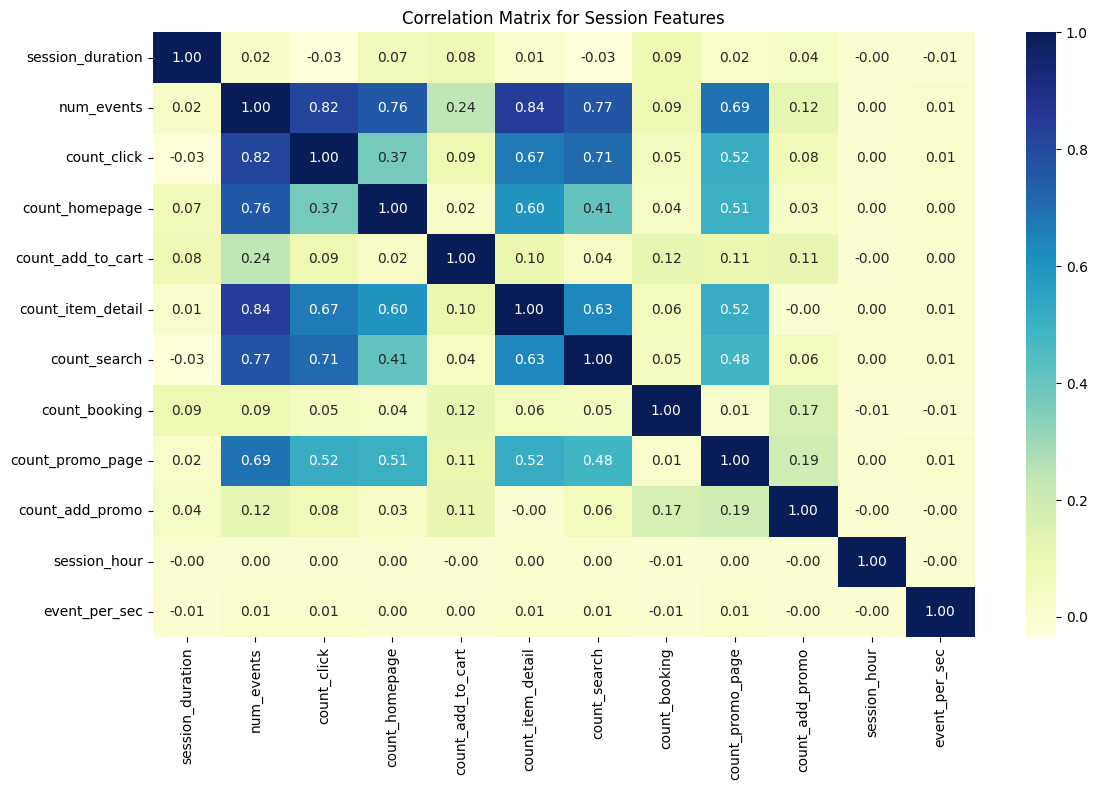

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = session_agg.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Correlation Matrix for Session Features")
plt.tight_layout()
plt.show()


In [ ]:
session_agg.to_csv('session_agg_df.csv')


In [ ]:
# Choose relevant columns
cols = session_agg.columns
# Create summary stats
summary_stats = session_agg[cols].describe().T[['50%', 'mean', 'std', 'min', 'max']]
summary_stats = summary_stats.rename(columns={'50%': 'Median', 'mean': 'Mean', 'std': 'Std Dev',
                                               'min': 'Min', 'max': 'Max'})

# Optional: round for readability
summary_stats = summary_stats.round(2)

summary_stats

,Median,Mean,Std Dev,Min,Max
session_duration,321978.0,950343.57,2314651.95,0.0,81620539.00
num_events,10.0,14.34,13.65,2.0,650.00
count_click,2.0,2.79,3.58,0.0,63.00
count_homepage,2.0,2.78,5.20,1.0,450.00
count_add_to_cart,1.0,2.16,2.20,0.0,52.00
count_item_detail,1.0,1.44,2.17,0.0,74.00
count_search,1.0,1.31,1.96,0.0,37.00
count_booking,1.0,0.95,0.21,0.0,1.00
count_promo_page,0.0,0.68,1.16,0.0,63.00
count_add_promo,0.0,0.36,0.48,0.0,1.00


In [ ]:
import pandas as pd
transactions_df = pd.read_csv('/content/drive/MyDrive/ML_Group_Project/transactions.csv')


In [ ]:
#Featue Engineering for Transactions Data
transactions_df.head()

,created_at,customer_id,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,"[{'product_id': 54728, 'quantity': 1, 'item_pr...",Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,"[{'product_id': 16193, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,"[{'product_id': 53686, 'quantity': 4, 'item_pr...",OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,"[{'product_id': 20228, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,"[{'product_id': 55220, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753


In [ ]:
# Modify the transaction dataset to seperate the product id and amoutn from the product_metadata column

transactions_mod_2 = transactions_df.copy()

# Create empty lists to store the extracted values
product_ids = []
quantities = []

for entry in transactions_mod_2['product_metadata']:
    try:
        # Only process if the entry is a string
        if isinstance(entry, str):
            # Extract product_id
            prod_id = entry.split("'product_id':")[1].split(",")[0].strip()
            qty = entry.split("'quantity':")[1].split(",")[0].strip()

            # Append extracted values
            product_ids.append(int(prod_id))
            quantities.append(int(qty))
        else:
            product_ids.append(None)
            quantities.append(0)
    except Exception:
        # If any error occurs during parsing, fallback to default values
        product_ids.append(None)
        quantities.append(0)

# Assign the new columns
transactions_mod_2['product_id'] = product_ids
transactions_mod_2['amount'] = quantities
# transactions_mod_2.head()

# transactions_mod.head()
transactions_mod_2.drop(columns=['product_metadata'], inplace=True)
transactions_mod_2.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,amount
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696,53686,4
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012,20228,1
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753,55220,1


In [ ]:
product_df = pd.read_csv('/content/drive/MyDrive/ML_Group_Project/product.csv', on_bad_lines='skip')
merged_transactions_product = transactions_mod_2.merge(product_df, left_on='product_id', right_on='id', how='left')


In [ ]:
merged_transactions_product.to_csv('merged_customer_transactions.csv')


In [ ]:
import pandas as pd
merged_transactions_product = pd.read_csv('merged_customer_transactions.csv')

In [ ]:

merged_transactions_product.rename(columns={
    'amount': 'quantity_ordered',
}, inplace=True)

In [ ]:
merged_transactions_product.columns

Index(['Unnamed: 0', 'created_at', 'customer_id', 'booking_id', 'session_id',
       'payment_method', 'payment_status', 'promo_amount', 'promo_code',
       'shipment_fee', 'shipment_date_limit', 'shipment_location_lat',
       'shipment_location_long', 'total_amount', 'product_id',
       'quantity_ordered', 'id', 'gender', 'masterCategory', 'subCategory',
       'articleType', 'baseColour', 'season', 'year', 'usage',
       'productDisplayName'],
      dtype='object')

In [ ]:
#Create new features here
merged_transactions_product['num_sessions_per_customer'] = merged_transactions_product.groupby('customer_id')['session_id'].transform('nunique')


In [ ]:
merged_df = session_agg.merge(merged_transactions_product, on="session_id", how="left")

In [ ]:
asd = merged_df.groupby('customer_id')['session_duration'].mean().reset_index()
asd.columns = ['customer_id', 'avg_session_duration']
merged_df = merged_df.merge(asd, on='customer_id', how='left')


In [ ]:
merged_df.head()

,session_id,session_duration,num_events,funnel_sequence,count_click,count_homepage,count_add_to_cart,count_item_detail,count_search,count_booking,...,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,num_sessions_per_customer,avg_session_duration
0,00001f29-3ede-4445-95f0-0178934e32ba,2.031120e+05,8,HOMEPAGE→ADD_TO_CART→BOOKING→HOMEPAGE→CLICK→CL...,2,2,1,1,0,1,...,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,Puma Women Janine Dance Black Shoes,250.0,2.462289e+05
1,00003eca-954b-4150-aee1-63fc62f395cf,2.335813e+03,4,HOMEPAGE→ADD_TO_CART→BOOKING→PROMO_PAGE,0,1,1,0,0,1,...,Accessories,Bags,Handbags,Black,Summer,2012.0,Casual,Murcia Women Black Handbag,150.0,2.067626e+05
2,0000425b-ddc8-4459-a240-6ba814dac132,7.072142e+06,4,HOMEPAGE→ADD_TO_CART→BOOKING→PROMO_PAGE,0,1,1,0,0,1,...,Personal Care,Skin,Face Moisturisers,White,Spring,2017.0,NaN,Lotus Herbals Acne Gel,14.0,3.042543e+06
3,00005746-17ec-449c-9c5c-699a3ea9304a,2.560000e+02,66,HOMEPAGE→ADD_TO_CART→BOOKING→CLICK→SCROLL→SEAR...,23,9,1,8,11,1,...,Apparel,Topwear,Jackets,Black,Fall,2011.0,Sports,Nike Men As Sideline J Black Jackets,155.0,1.536159e+05
4,0000649b-9514-4600-979b-42166a798996,5.219070e+05,18,HOMEPAGE→ADD_TO_CART→ADD_PROMO→BOOKING→CLICK→C...,3,3,3,3,1,1,...,Accessories,Bags,Backpacks,Black,Summer,2012.0,Casual,Cabarelli Men Black Backpack,6.0,3.295924e+06


In [ ]:
merged_df.shape

(895203, 47)

In [ ]:
# Merge with Transactions and Customers Data
customer_df = pd.read_csv('/content/drive/MyDrive/ML_Group_Project/customer.csv')
filtered_customer_df = customer_df[['customer_id', 'gender', 'home_country', 'first_join_date']]

In [ ]:
merged_df.shape

(895203, 47)

In [ ]:
merged_df.columns

Index(['session_id', 'session_duration', 'num_events', 'funnel_sequence',
       'count_click', 'count_homepage', 'count_add_to_cart',
       'count_item_detail', 'count_search', 'count_booking',
       'count_promo_page', 'count_add_promo', 'session_hour', 'event_per_sec',
       'Unnamed: 0', 'created_at', 'customer_id', 'booking_id',
       'payment_method', 'payment_status', 'promo_amount', 'promo_code',
       'shipment_fee', 'shipment_date_limit', 'shipment_location_lat',
       'shipment_location_long', 'total_amount', 'product_id',
       'quantity_ordered', 'id', 'gender_x', 'masterCategory', 'subCategory',
       'articleType', 'baseColour', 'season', 'year', 'usage',
       'productDisplayName', 'num_sessions_per_customer',
       'avg_session_duration', 'gender_y', 'home_country_x',
       'first_join_date_x', 'gender', 'home_country_y', 'first_join_date_y'],
      dtype='object')

(895203, 47)